In [1]:
# 导入合适的库
import numpy as np
import torch
import gpytorch
import matplotlib.pyplot as plt
from GPRmodel import GPRmodel

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [20]:
# 导入数据
params = np.loadtxt('0915params_2475year.txt')
edpResults = np.loadtxt('0915edpResult_2475year.txt')

params = params[:, (1, 2, 3, 4, 5, 6, 7, 8, 10)]

X_predict = params
Y_predict = GPRmodel(X_predict)

# X_predict = np.hstack((X_predict, np.exp(Y_predict[:, :3])))
# params = X_predict
np.savetxt('param_pred.txt', Y_predict[:700, (0, 1, 2)])

In [3]:
# 检查params数据是否正确 [T1, mb, kesi, PGA, PGV, PGD, Sd, Sv, Sa]9 theta1: Ia; theta2: D_5-95; theta3: t_mid; theta4: w_mid; theta5: w'; theta6: kesi_f 6 MRVF
#                        0   1    2     3    4    5   6   7   8            9             10             11              12           13            14   
print(params.shape)  
params

(1040, 12)


array([[1.07001820e+00, 3.41753683e-02, 1.44143855e+01, ...,
        1.68370698e-02, 1.88458506e-02, 1.14213759e-02],
       [9.39678177e-01, 3.74978086e-02, 1.14275351e+01, ...,
        1.82970632e-02, 1.53113538e-02, 8.24177358e-03],
       [1.11246337e+00, 2.83235782e-02, 1.86685135e+01, ...,
        3.04235108e-02, 2.28708852e-02, 1.16930455e-02],
       ...,
       [1.11903868e+00, 3.38242508e-02, 1.41571810e+01, ...,
        1.38012758e-02, 1.42483804e-02, 8.99087265e-03],
       [1.07694660e+00, 4.36945601e-02, 1.03387621e+01, ...,
        1.77634731e-02, 1.71621032e-02, 9.16692521e-03],
       [9.43091938e-01, 4.01084932e-02, 1.16677655e+01, ...,
        2.02503521e-02, 1.81694329e-02, 8.97810515e-03]])

In [4]:
# 检查edpResults数据是否正确 [IDR1_MAX, IDR2_MAX, IDR3_MAX, amax0, amax1, amax2, amax3, residual_idr]
print(edpResults.shape)
edpResults = np.log(edpResults)

(1040, 8)


In [5]:
from sklearn.preprocessing import StandardScaler
# 创建 StandardScaler 实例
scaler = StandardScaler()
# 假设 X 是输入特征数据
# 在训练集上拟合（计算均值和方差），并对数据进行标准化
nn = 700
X_train_scaled = scaler.fit_transform(params[:nn])
# 在测试集上使用相同的标准化器进行标准化
X_test_scaled = scaler.transform(params[nn:])

In [6]:
# 数据抓换成torch格式
n = 7
num, dims = params.shape
train_x = torch.from_numpy(X_train_scaled).to(torch.float)
train_y = torch.from_numpy(edpResults[:nn, n]).to(torch.float)

In [7]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=dims))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [8]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 200


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    # print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
    #     i + 1, training_iter, loss.item(),
    #     model.covar_module.base_kernel.lengthscale.item(),
    #     model.likelihood.noise.item()
    # ))
    print('Iter %d/%d' % (i + 1, training_iter))
    print(model.covar_module.base_kernel.lengthscale)
    optimizer.step()

Iter 1/200
tensor([[0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931,
         0.6931, 0.6931, 0.6931]], grad_fn=<SoftplusBackward0>)
Iter 2/200
tensor([[0.7444, 0.7444, 0.7444, 0.7444, 0.7444, 0.6931, 0.7444, 0.6931, 0.7444,
         0.7444, 0.7444, 0.7444]], grad_fn=<SoftplusBackward0>)
Iter 3/200
tensor([[0.7975, 0.7975, 0.7981, 0.7979, 0.7979, 0.6931, 0.7981, 0.6931, 0.7981,
         0.7978, 0.7978, 0.7977]], grad_fn=<SoftplusBackward0>)
Iter 4/200
tensor([[0.8519, 0.8519, 0.8541, 0.8533, 0.8534, 0.6931, 0.8539, 0.6931, 0.8540,
         0.8528, 0.8528, 0.8527]], grad_fn=<SoftplusBackward0>)
Iter 5/200
tensor([[0.9070, 0.9070, 0.9120, 0.9100, 0.9104, 0.6931, 0.9114, 0.6931, 0.9119,
         0.9090, 0.9090, 0.9087]], grad_fn=<SoftplusBackward0>)
Iter 6/200
tensor([[0.9622, 0.9621, 0.9713, 0.9674, 0.9683, 0.6931, 0.9702, 0.6931, 0.9714,
         0.9659, 0.9658, 0.9653]], grad_fn=<SoftplusBackward0>)
Iter 7/200
tensor([[1.0169, 1.0167, 1.0314, 1.0249, 1.0268, 0.69

In [9]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.from_numpy(X_test_scaled).to(torch.float)
    observed_pred_test = likelihood(model(test_x))

In [10]:
from sklearn.metrics import r2_score
r_squared_sklearn_test = r2_score(edpResults[nn:, n], observed_pred_test.mean.numpy())
print(r_squared_sklearn_test)

0.8790655301509265


In [11]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred_train = likelihood(model(train_x))

c:\ProgramData\miniconda3\envs\torchenv310\lib\site-packages\gpytorch\models\exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


In [12]:
model.state_dict()

OrderedDict([('likelihood.noise_covar.raw_noise', tensor([-2.6647])),
             ('likelihood.noise_covar.raw_noise_constraint.lower_bound',
              tensor(1.0000e-04)),
             ('likelihood.noise_covar.raw_noise_constraint.upper_bound',
              tensor(inf)),
             ('mean_module.raw_constant', tensor(-4.6510)),
             ('covar_module.raw_outputscale', tensor(2.0578)),
             ('covar_module.base_kernel.raw_lengthscale',
              tensor([[ 5.5329e-01,  2.7609e+00,  1.5168e+00,  4.4327e-01,  1.1592e+00,
                       -1.7807e-23, -1.1410e-01, -2.6423e-20,  2.1787e+00,  1.2016e+00,
                        1.1923e+00,  1.8439e+00]])),
             ('covar_module.base_kernel.raw_lengthscale_constraint.lower_bound',
              tensor(0.)),
             ('covar_module.base_kernel.raw_lengthscale_constraint.upper_bound',
              tensor(inf)),
             ('covar_module.raw_outputscale_constraint.lower_bound',
              tensor(0.))

In [13]:
torch.save(model.state_dict(), 'ridr_model_state.pth')

In [14]:
from sklearn.metrics import r2_score
r_squared_sklearn_train = r2_score(edpResults[:nn, n], observed_pred_train.mean.numpy())
print(r_squared_sklearn_train)

0.9703037082781684


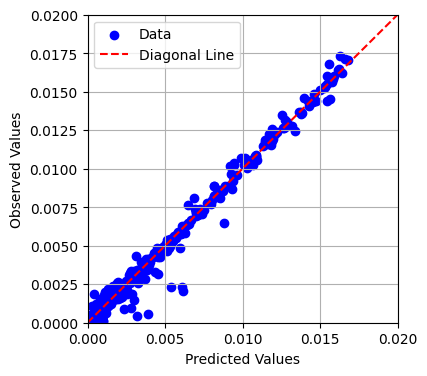

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# 生成示例数据（模拟预测值和观测值）
np.random.seed(0)
# observed_values = edpResults[:1600, 0]
# predicted_values = observed_pred_train.mean.numpy()
observed_values = np.exp(edpResults[nn:, n])
predicted_values = np.exp(observed_pred_test.mean.numpy())
# 绘制散点图和对角线
a = 4
plt.figure(figsize=(4,4))
plt.scatter(predicted_values, observed_values, color='blue', label='Data')
plt.plot([0, a], [0, a], color='red', linestyle='--', label='Diagonal Line')
plt.xlabel('Predicted Values')
plt.ylabel('Observed Values')
plt.xlim([0, 0.02])
plt.ylim([0, 0.02])
# plt.title('QQ Plot with Diagonal Line')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
np.savetxt('pidr1_ob.txt', observed_values)
np.savetxt('pidr1_pr.txt', predicted_values)

In [17]:
from sklearn.metrics import r2_score
r_squared_sklearn_test = r2_score(observed_values, predicted_values)
print(r_squared_sklearn_test)

0.9830507029858789


In [18]:
from sklearn.metrics import mean_squared_error
MSE = mean_squared_error(observed_values, predicted_values)
print(np.sqrt(MSE))

0.0006007155710086807


In [19]:
# import numpy as np
# import matplotlib.pyplot as plt

# # 生成示例数据（模拟预测值和观测值）
# np.random.seed(0)
# # observed_values = edpResults[:1600, 0]
# # predicted_values = observed_pred_train.mean.numpy()
# observed_values = np.exp(edpResults[:700, n])
# predicted_values = np.exp(observed_pred_train.mean.numpy())
# # 绘制散点图和对角线
# a = 0.1
# plt.figure(figsize=(4,4))
# plt.scatter(predicted_values, observed_values, color='blue', label='Data')
# plt.plot([0, a], [0, a], color='red', linestyle='--', label='Diagonal Line')
# plt.xlabel('Predicted Values')
# plt.ylabel('Observed Values')
# plt.xlim([0, 0.04])
# plt.ylim([0, 0.04])
# # plt.title('QQ Plot with Diagonal Line')
# plt.legend()
# plt.grid(True)
# plt.show()